In [84]:
# @hidden_cell
# Get rid of annoying warnings
import warnings
warnings.filterwarnings('ignore')

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [86]:
# Initialize Global Settings
plt.rc("font", size=14) # Set Font Size
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)


In [87]:
# Read in Data and convert to pandas data frame
data_raw = pd.read_csv('dataset.csv',skipinitialspace=True,header = 0,na_values=[" "])
data = pd.DataFrame(data_raw)
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,sal-Ind
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [88]:
# View Descriptive Statistics
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [89]:
# Get count of missing values by field
data.isnull().sum()[data.isnull().sum() > 0]

workclass         1836
occupation        1843
native-country     583
dtype: int64

In [90]:
#dropping null values
data = data.dropna()
len(data)

30162

In [91]:
# Get count of missing values by field
data.isnull().sum()[data.isnull().sum() > 0]

Series([], dtype: int64)

In [92]:
# Means of continous variables by salary
data.groupby('sal-Ind').mean()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
sal-Ind,,,,,,
<=50K,36.60806,190338.646729,9.629116,148.893838,53.448000,39.348592
>50K,43.95911,188149.962174,11.606420,3937.679808,193.750666,45.706580


In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 15 columns):
age               30162 non-null int64
workclass         30162 non-null object
fnlwgt            30162 non-null int64
education         30162 non-null object
education-num     30162 non-null int64
marital-status    30162 non-null object
occupation        30162 non-null object
relationship      30162 non-null object
race              30162 non-null object
sex               30162 non-null object
capital-gain      30162 non-null int64
capital-loss      30162 non-null int64
hours-per-week    30162 non-null int64
native-country    30162 non-null object
sal-Ind           30162 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [94]:
#encoding response variable(sal-Ind) as 1(>50K) and 0(<=50K)
data['sal-Ind'] = data['sal-Ind'].map({'<=50K': 0, '>50K': 1})

In [95]:
NorthAmerica = ["Canada", "Cuba", "Dominican-Republic", "El-Salvador", "Guatemala",
                   "Haiti", "Honduras", "Jamaica", "Mexico", "Nicaragua",
                   "Outlying-US(Guam-USVI-etc)", "Puerto-Rico", "Trinadad&Tobago",
                   "United-States"]
Asia = ["Cambodia", "China", "Hong", "India", "Iran", "Japan", "Laos",
          "Philippines", "Taiwan", "Thailand", "Vietnam"]
SouthAmerica = ["Columbia", "Ecuador", "Peru"]
Europe = ["England", "France", "Germany", "Greece", "Holand-Netherlands",
            "Hungary", "Ireland", "Italy", "Poland", "Portugal", "Scotland",
            "Yugoslavia"]
Other = ["South", "?"]



In [96]:
continents = {country: 'Asia' for country in Asia}
continents.update({country: 'Europe' for country in Europe})
continents.update({country: 'NorthAmerica' for country in NorthAmerica})
continents.update({country: 'SouthAmerica' for country in SouthAmerica})
continents.update({country: 'Other' for country in Other})
#continents

In [97]:
data['native-country'] = data['native-country'].map(continents)

In [98]:
data['native-country'].value_counts()

NorthAmerica    28851
Asia              634
Europe            493
SouthAmerica      113
Other              71
Name: native-country, dtype: int64

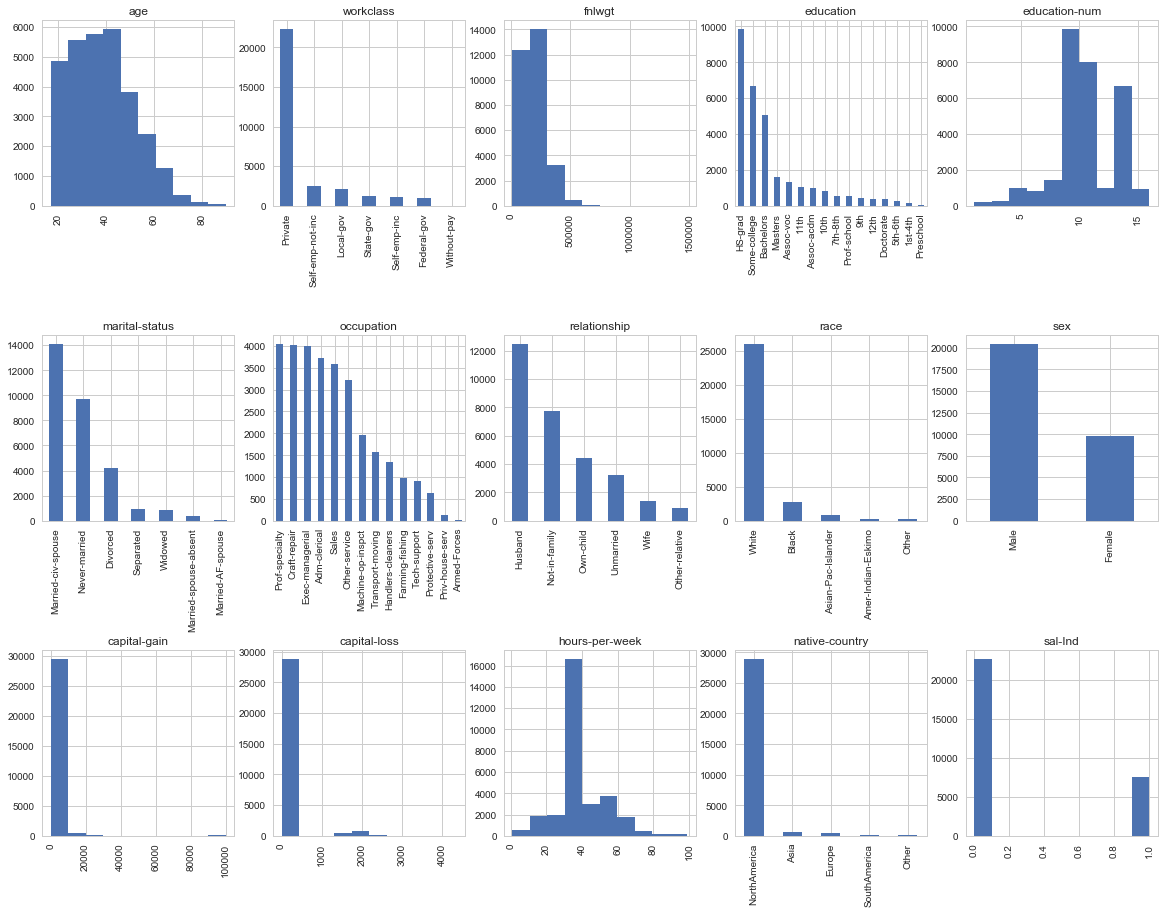

In [99]:
import math
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(data.shape[1]) / cols)
for i, column in enumerate(data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data.dtypes[column] == np.object:
        data[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.show()

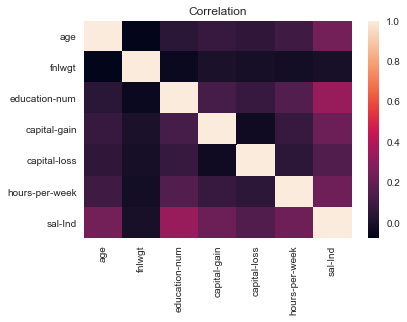

In [100]:
x=data.corr()
sns.heatmap(x)
plt.title("Correlation")
plt.show()

In [101]:
# View correlations with class
x['sal-Ind'].sort_values(ascending=False)

sal-Ind           1.000000
education-num     0.335286
age               0.241998
hours-per-week    0.229480
capital-gain      0.221196
capital-loss      0.150053
fnlwgt           -0.008957
Name: sal-Ind, dtype: float64

In [102]:
#Creating Dummies
data2=pd.get_dummies(data,columns=['workclass','education','marital-status','occupation','relationship',
                                   'race','sex','native-country'])
print("Data shape:", data2.shape)
for i,j in enumerate(list(data2.columns)):
    print (str(i) + ": " + j)

Data shape: (30162, 69)
0: age
1: fnlwgt
2: education-num
3: capital-gain
4: capital-loss
5: hours-per-week
6: sal-Ind
7: workclass_Federal-gov
8: workclass_Local-gov
9: workclass_Private
10: workclass_Self-emp-inc
11: workclass_Self-emp-not-inc
12: workclass_State-gov
13: workclass_Without-pay
14: education_10th
15: education_11th
16: education_12th
17: education_1st-4th
18: education_5th-6th
19: education_7th-8th
20: education_9th
21: education_Assoc-acdm
22: education_Assoc-voc
23: education_Bachelors
24: education_Doctorate
25: education_HS-grad
26: education_Masters
27: education_Preschool
28: education_Prof-school
29: education_Some-college
30: marital-status_Divorced
31: marital-status_Married-AF-spouse
32: marital-status_Married-civ-spouse
33: marital-status_Married-spouse-absent
34: marital-status_Never-married
35: marital-status_Separated
36: marital-status_Widowed
37: occupation_Adm-clerical
38: occupation_Armed-Forces
39: occupation_Craft-repair
40: occupation_Exec-manageri

In [103]:
cols = data2.columns.tolist()
cols.insert(0, cols.pop(cols.index('sal-Ind')))
data2 = data2.reindex(columns= cols)
#data2

In [104]:
#Building Logistic Regression Model for selecting important features using Recursive Feature Elimination(RFE)
A = data2.iloc[:,1:]
b = data2.iloc[:,0]
classifier = LogisticRegression(random_state = 5)
from sklearn.feature_selection import RFE
rfe = RFE(classifier,29)
classifier = rfe.fit(A, b)
print("Num Features: %d" % (classifier.n_features_,))
print("Selected Features: %s" % (classifier.support_,))
print("Feature Ranking: %s" % (classifier.ranking_,))
data2.shape
asdf = (classifier.support_,)
q = asdf[0].tolist()
#print(q)
dip = []        
for i, j in enumerate (q) :
    if j == False:
        dip.append(i+1)
data2 = data2.drop(data2.columns[dip], axis=1)
data2.columns


Num Features: 29
Selected Features: [False False False False False False  True False False  True False False
  True False False False False False False False False False False  True
 False False  True  True False  True False  True  True  True  True  True
 False False False  True  True  True False  True  True  True  True  True
  True False False False  True  True False  True  True False False  True
 False  True False False False False  True  True]
Feature Ranking: [30 35  6 34 33 28  1 38 22  1  8  3  1 16 10 11 25 18 15 13  5 12 27  1
 14  9  1  1 17  1 36  1  1  1  1  1 29 39 31  1  1  1  2  1  1  1  1  1
  1 26 23 24  1  1  7  1  1 20 19  1 21  1  4 40 37 32  1  1]


Index(['sal-Ind', 'workclass_Federal-gov', 'workclass_Self-emp-inc',
       'workclass_Without-pay', 'education_Doctorate', 'education_Preschool',
       'education_Prof-school', 'marital-status_Divorced',
       'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'relationship_Other-relative',
       'relationship_Own-child', 'relationship_Wife',
       'race_Amer-Indian-Eskimo', 'race_Other', 'sex_Female',
       'native-country_Other', 'native-country_SouthAmerica'],
      dtype='object')

In [105]:
#Building model after feature selection ---split data into train and test
X = data2.iloc[:,1:]
y = data2.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.25,random_state = 5)


In [106]:
#Building Logistic Regression Model
classifier = LogisticRegression(random_state = 5)
classifier.fit(X_train, y_train)
from sklearn.metrics import confusion_matrix
#Predicting and Confusion Matrix
y_pred = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)[:, 1]
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[5231  397]
 [1007  906]]


In [107]:
#Caluclating Accuracy
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))


Accuracy of logistic regression classifier on test set: 0.81


In [108]:
#Caluclating Precision and F-score
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.84      0.93      0.88      5628
          1       0.70      0.47      0.56      1913

avg / total       0.80      0.81      0.80      7541



In [109]:
#Weights of each feature
classifier.coef_

array([[ 0.7298421 ,  0.56857298, -0.7611871 ,  1.47030988, -1.27510103,
         1.35823874, -0.7693503 ,  0.6753385 , -0.77785965, -1.32154632,
        -0.98886971, -0.50617282,  1.45877652, -0.72976067, -0.81761685,
        -0.99988993, -1.11212132,  1.39354679,  0.62825674,  0.77990894,
         0.96978153, -0.96347703, -1.61122845,  1.21826376, -0.79563552,
        -1.16073415, -1.02473345, -0.75880838, -1.360781  ]])

In [110]:
#K-fold cross validation
from sklearn import model_selection
fold = model_selection.KFold(n_splits=10, random_state=7)
scores = cross_val_score(classifier, X, y, cv=fold)
print(scores)
print('average accuracy: {}'.format(scores.mean()))

[0.8080875  0.82532317 0.82029178 0.80603448 0.81863395 0.80669761
 0.8219496  0.81863395 0.81763926 0.80769231]
average accuracy: 0.815098361715091


Area under ROC: 0.8625105002951785


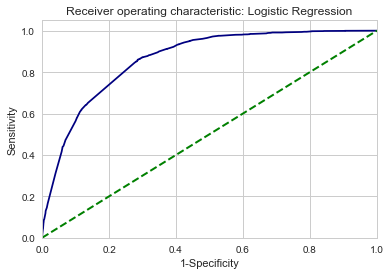

In [111]:
#Define a function to draw ROC
def drawROC(y_test, y_pred_prob, cl_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], th_ = roc_curve(y_test, y_pred_prob)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    print("Area under ROC:",roc_auc_score(y_test, y_pred_prob))
    plt.figure()
    plt.plot(fpr[1], tpr[1], color = 'navy')
    plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Receiver operating characteristic: '+cl_name)
    plt.show()

#ROC of logistic Regression
drawROC(y_test, y_pred_prob, 'Logistic Regression')

In [112]:
#Support Vector Machines
from sklearn import svm
svc = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
y_pred = svc.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix1 = confusion_matrix(y_test, y_pred)
print(confusion_matrix1)

[[5072  556]
 [ 865 1048]]


In [113]:
#Caluclating Accuracy
print('Accuracy of SVM classifier on test set: {:.2f}'.format(svc.score(X_test, y_test)))

Accuracy of SVM classifier on test set: 0.81


In [114]:
#Caluclating Precision and F-score
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.85      0.90      0.88      5628
          1       0.65      0.55      0.60      1913

avg / total       0.80      0.81      0.81      7541



In [115]:
#KNN Classifier with 3 neighbors
from sklearn.neighbors import KNeighborsClassifier
classifier_KNN = KNeighborsClassifier(n_neighbors=3)
classifier_KNN.fit(X_train, y_train)
y_pred = classifier_KNN.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix1 = confusion_matrix(y_test, y_pred)
print(confusion_matrix1)

[[4336 1292]
 [ 708 1205]]


In [116]:
#Caluclating Accuracy
print('Accuracy of KNN classifier on test set: {:.2f}'.format(classifier_KNN.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.73


In [117]:
y_pred=classifier_KNN.predict(X_test)
#Classification Report
print(classification_report(y_test, y_pred, target_names=["0","1"]))

             precision    recall  f1-score   support

          0       0.86      0.77      0.81      5628
          1       0.48      0.63      0.55      1913

avg / total       0.76      0.73      0.75      7541



In [39]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten

Using TensorFlow backend.


In [40]:
model = Sequential()
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [41]:
# Adding the input layer and the first hidden layer
model.add(Dense(output_dim = 15, init = 'uniform', activation = 'relu', input_dim = 29))
# Adding the second hidden layer
model.add(Dense(output_dim = 15, init = 'uniform', activation = 'relu'))
# Adding the output layer
model.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

In [44]:
# Compiling Neural Network
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
#classifier.add(Flatten())

In [45]:
# Fitting our model 
model_history = model.fit(X_train, y_train, batch_size = 10, epochs = 100)

Epoch 1/100
22621/22621 [==============================] - 3s 117us/step - loss: 0.4000 - acc: 0.8183
Epoch 2/100
22621/22621 [==============================] - 2s 97us/step - loss: 0.3999 - acc: 0.8183
Epoch 3/100
22621/22621 [==============================] - 2s 92us/step - loss: 0.3997 - acc: 0.8180
Epoch 4/100
22621/22621 [==============================] - 2s 92us/step - loss: 0.3985 - acc: 0.8184
Epoch 5/100
22621/22621 [==============================] - 2s 92us/step - loss: 0.4012 - acc: 0.8187
Epoch 6/100
22621/22621 [==============================] - 2s 93us/step - loss: 0.3998 - acc: 0.8188
Epoch 7/100
22621/22621 [==============================] - 3s 113us/step - loss: 0.3987 - acc: 0.8179
Epoch 8/100
22621/22621 [==============================] - 2s 108us/step - loss: 0.4002 - acc: 0.8186
Epoch 9/100
22621/22621 [==============================] - 3s 121us/step - loss: 0.3997 - acc: 0.8179
Epoch 10/100
22621/22621 [==============================] - 2s 102us/step - loss: 0.400

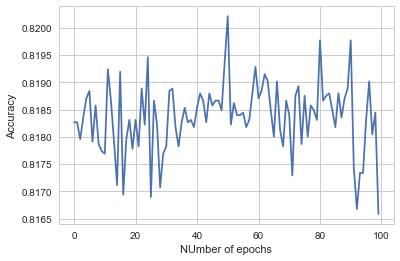

In [55]:
#plotting NUmber of epochs vs Accuracy
plt.plot(model_history.history['acc'])
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.show()

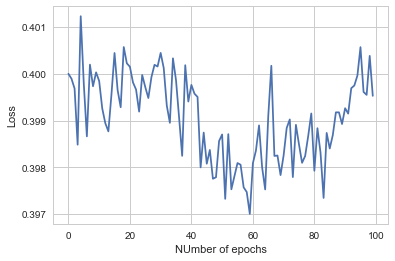

In [56]:
#plotting number of epochs vs loss
plt.plot(model_history.history['loss'])
plt.xlabel('NUmber of epochs')
plt.ylabel('Loss')
plt.show()

In [67]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

In [68]:
# Creating the Confusion Matrix of neural network predictions
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[3751 1877]
 [ 240 1673]]


In [69]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.94      0.67      0.78      5628
          1       0.47      0.87      0.61      1913

avg / total       0.82      0.72      0.74      7541

